In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import os
import sys
from glob import glob

import librosa
import matplotlib.pyplot as plt
import numpy as np
import yaml
from loguru import logger
from scipy.io import wavfile

from enfify.config import ENFIFY_DIR, INTERIM_DATA_DIR, PROCESSED_DATA_DIR
from enfify.feature_calculation import (compute_if,
                                   compute_max_energy_frequency_over_time)
from enfify.pipeline import freq_feature_pipeline

In [3]:
logger.remove()
logger.add(sys.stderr, level="WARNING")

2

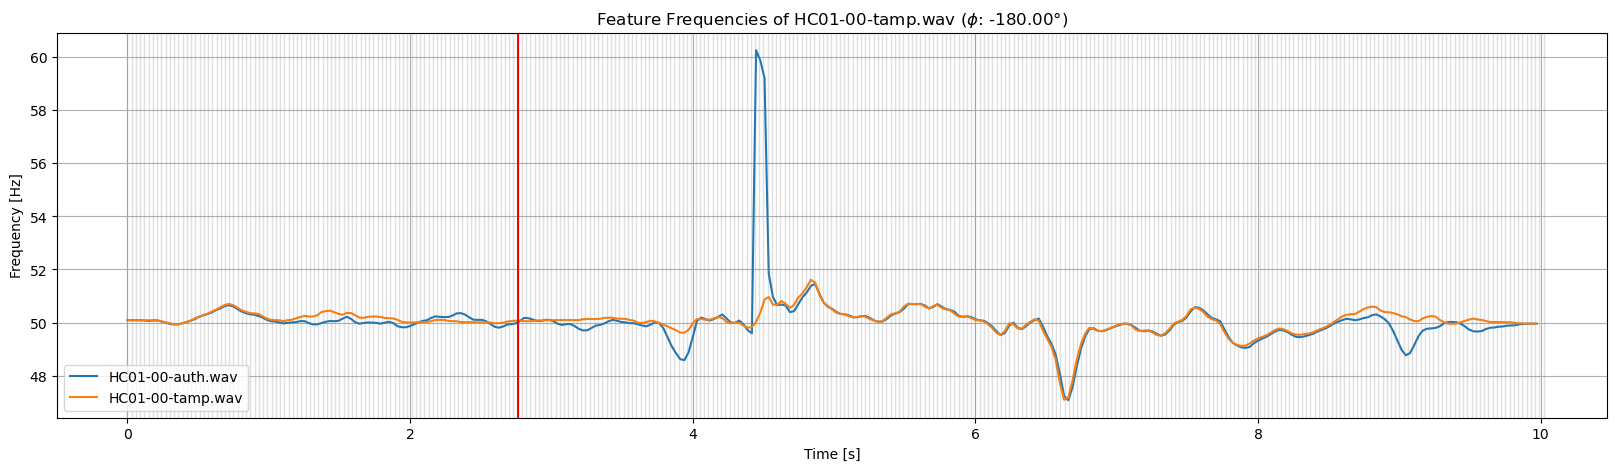

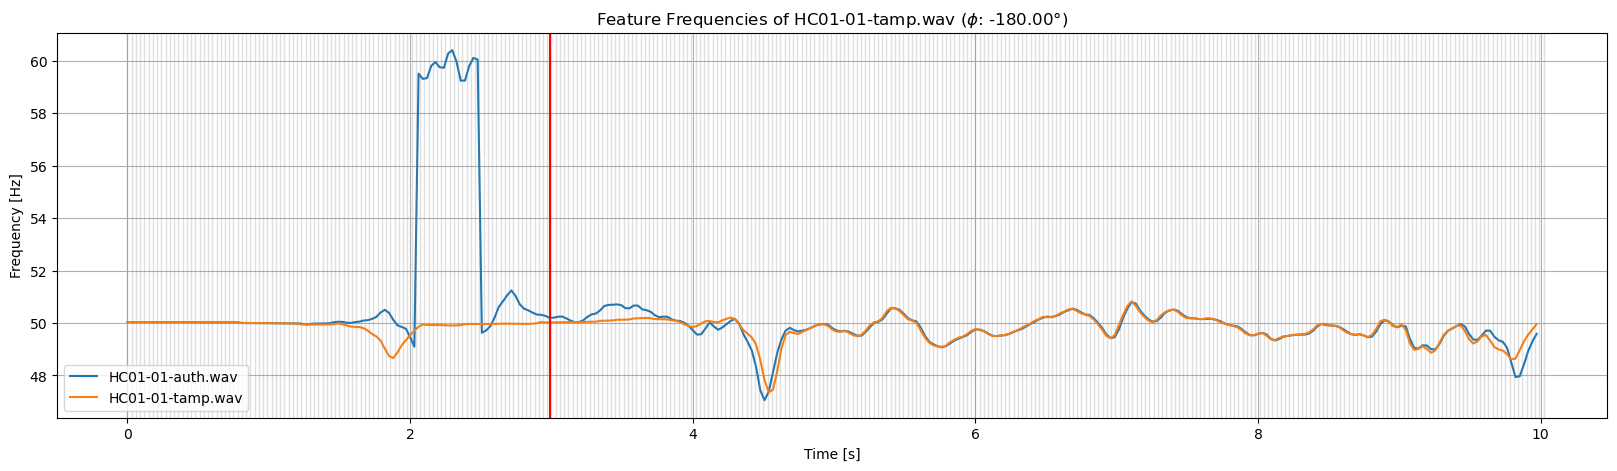

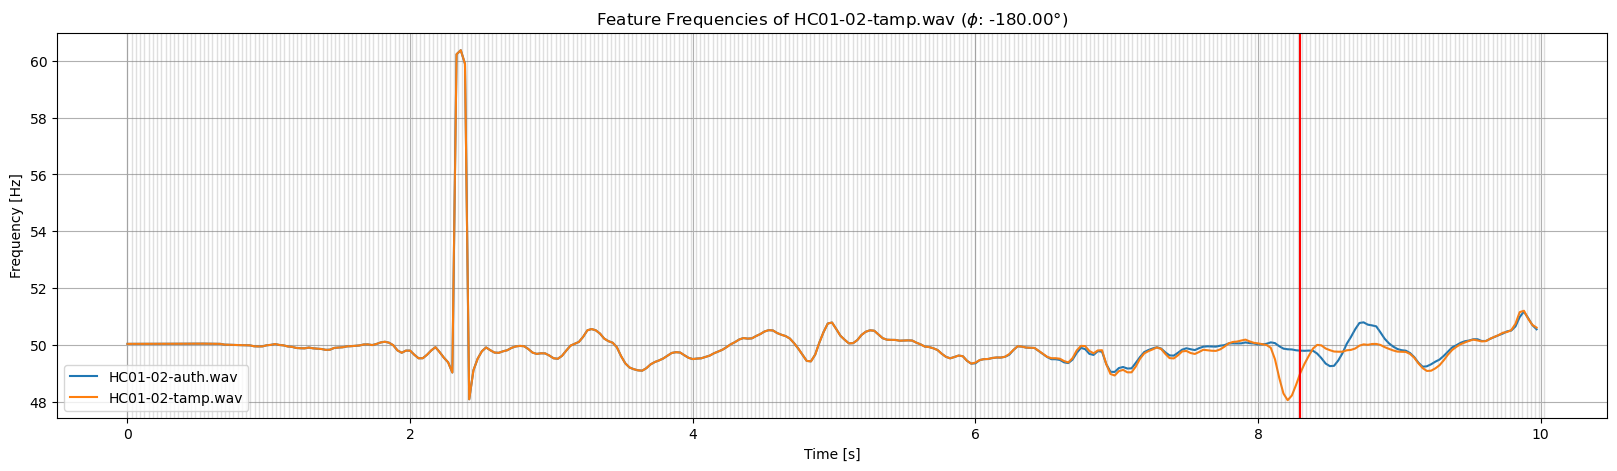

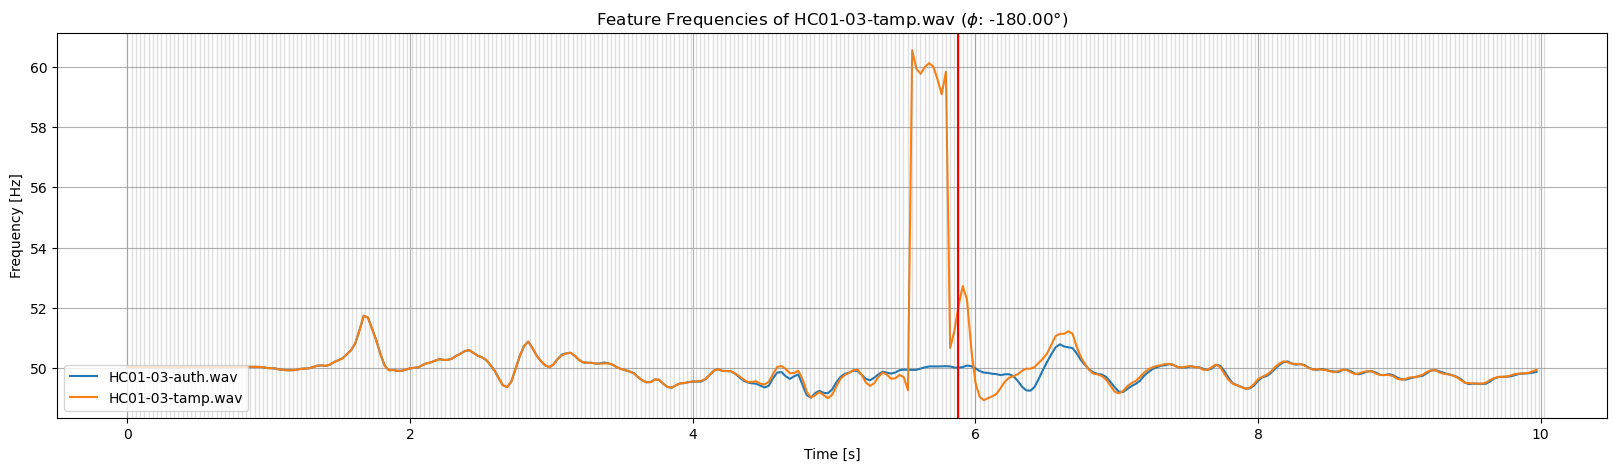

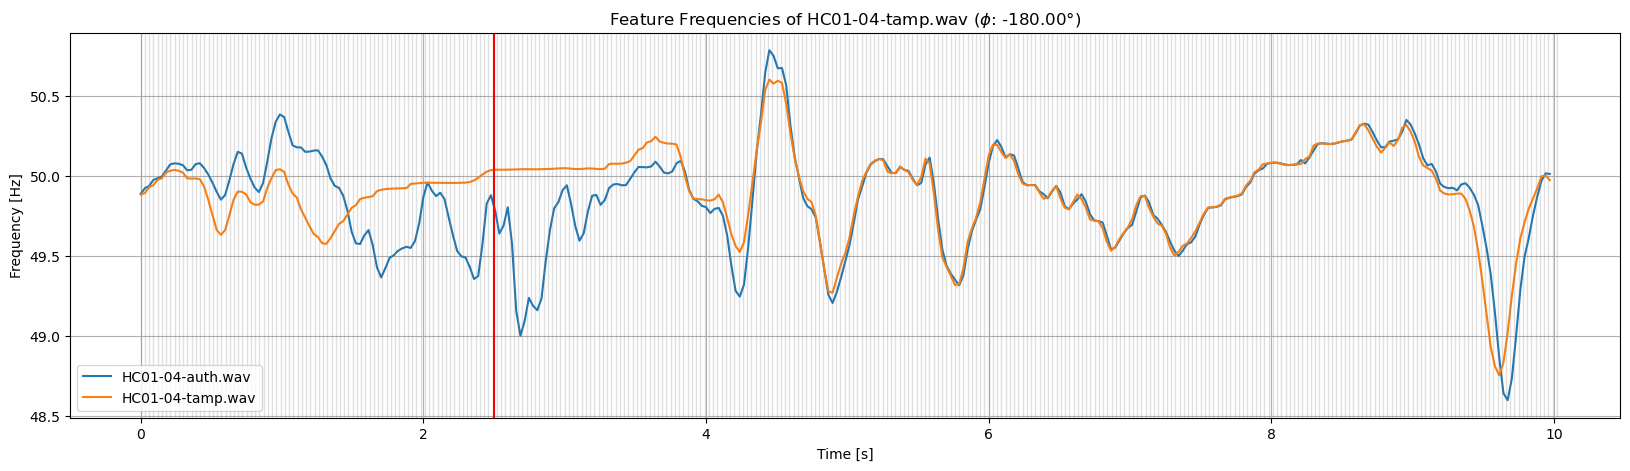

In [4]:
with open(ENFIFY_DIR/"config_nature.yml", "r") as f:
    config = yaml.safe_load(f)

with open(INTERIM_DATA_DIR / "Carioca1" / "cut_info.json", "r") as f:
    cut_info = json.load(f)

files = sorted(glob(str(INTERIM_DATA_DIR / "Carioca1" / "*.wav")))
files = list(zip(files[::2], files[1::2]))

for auth, tamp in files[:5]:
    plt.figure(figsize=(20,5))
    for file in [auth, tamp]:
        # PROCESSING
        sample_freq, sig = wavfile.read(file)
        features = freq_feature_pipeline(sig, sample_freq, config)

        # PLOTTING
        time = np.linspace(0, len(sig) / sample_freq, len(features), endpoint=False)
        plt.plot(time, features, label=os.path.basename(file))
        
        if "tamp" in file:
            for i in range(len(features)):
                frame_shift = config["frame_len"] / 1000 * (1-config["frame_overlap"])
                plt.axvline(i * frame_shift, color="gray", lw=1, alpha=0.25)
            start = cut_info[os.path.basename(file)]["start"]
            cutlen = cut_info[os.path.basename(file)]["cutlen"]
            plt.axvline(start/sample_freq, color="red")
            nominal_enf = config["nominal_enf"]
            phi = (cutlen/sample_freq/(1/nominal_enf)*360 + 180) % 360 - 180
            phi_info = f" ($\phi$: {phi:.2f}°)"
        else:
            phi_info = ""
        
    plt.xlabel("Time [s]")
    plt.ylabel("Frequency [Hz]")
    plt.title(f"Feature Frequencies of {os.path.basename(file)}{phi_info}")
    plt.grid()
    plt.legend(loc="lower left")
    plt.show()